### Bài toán

Các khó khăn gặp phải khi xây dựng mô hình phân loại văn bản tiếng Việt:

1. Việc tách từ tiếng Việt khá là phức tạp do có nhiều từ và cụm từ ghép lại với nhau, nhiều từ không có trong từ điển.
2. Việc tìm được bộ từ điển tương đối đầy đủ khá khó khăn do tiếng Việt có nhiều từ ngữ cả trong lĩnh vực chuyên ngành và nhiều từ ngữ không có trong từ điển. Các từ mới, từ mượn được sinh ra hàng năm và chưa được cập nhật vào từ điển. Hiện tại mới chỉ tìm được một số ít từ phổ biến có trong các từ điển mở.
3. Việc triển khai mô hình phân loại văn bản tiếng Việt khá là khó khăn do không có nhiều tài liệu tham khảo, đặc biệt là các tài liệu về xử lý ngôn ngữ tự nhiên tiếng Việt.
4. Việc cài đặt môi trường lập trình cho Tensorflow cũng như pytorch gặp nhiều khó khăn khi cài đặt trên Windows, đặc biệt là khi sử dụng GPU.
5. Việc chuẩn hoá văn bản tiếng Việt gặp rất nhiều thách thức về:
    - Cách mã hoá văn bản Unicode
    - Cách bỏ dấu tiếng Việt
    - Xử lý sai chính tả
    - Xử lý từ viết tắt, tiếng địa phương, ...
    - Xử lý các từ ngữ không có trong từ điển
7. Việc tách từ cũng gặp rất nhiều bất lợi
    - Từ điển càng lớn thì việc tách từ càng chậm, đã thử nghiệm và tách từ mất 30p cho tập train.
    - Tokenization phải đào tạo mô hình để thực hiện mới đem lại hiệu quả tốt. Đã thử nghiệm với các thư viện như pyvi, underthesea, vncorenlp, ... nhưng kết quả không tốt. Chậm quá
    - Các thư viện tách từ tiếng Việt hiện tại chưa hỗ trợ tách từ cho các từ ngữ không có trong từ điển, các từ viết tắt, tiếng địa phương, ...
    - Đã phải tự xây dựng thuật toán tách từ và mang lại hiệu quả tạm chấp nhận được.

6. Hiện chưa có bộ StopWords tiếng Việt tương đối đầy đủ, nên việc xử lý StopWords cũng gặp nhiều khó khăn do đa phần là tự tạo không theo một tiêu chuẩn nào cả.
    - Đã tự viết chương trình thống kê các từ xuất hiện trong tập train và tập test để tạo bộ StopWords tuy nhiên vẫn còn thiếu sót và chưa đầy đủ.
    - Phải tìm đủ các từ đồng nghĩa để đưa vào bộ StopWords.

- Input: một đoạn văn bản
- Output: một trong các nhãn sau: Văn hoá, Kinh doanh, Thế giới, Thể thao, Pháp luật, Sức khoẻ, Đời sống, Chính trị xã hội, Khoa học, Vi tính

### Thu thập dữ liệu

Dữ liệu được lấy dừ https://github.com/duyvuleo/VNTC/tree/master/Data/10Topics/Ver1.1 với thông tin như sau:

**_Train_**

| Topic            | Topic ID | #files |
| ---------------- | -------- | ------ |
| Chinh tri Xa hoi | XH       | 5219   |
| Doi song         | DS       | 3159   |
| Khoa hoc         | KH       | 1820   |
| Kinh doanh       | KD       | 2552   |
| Phap luat        | PL       | 3868   |
| Suc khoe         | SK       | 3384   |
| The gioi         | TG       | 2898   |
| The thao         | TT       | 5298   |
| Van hoa          | VH       | 3080   |
| Vi tinh          | VT       | 2481   |

Total 33759

**_Test_**

| Topic            | Topic ID | #files |
| ---------------- | -------- | ------ |
| Chinh tri Xa hoi | XH       | 7567   |
| Doi song         | DS       | 2036   |
| Khoa hoc         | KH       | 2096   |
| Kinh doanh       | KD       | 5276   |
| Phap luat        | PL       | 3788   |
| Suc khoe         | SK       | 5417   |
| The gioi         | TG       | 6716   |
| The thao         | TT       | 6667   |
| Van hoa          | VH       | 6250   |
| Vi tinh          | VT       | 4560   |

Total 50373

Dữ liệu trong các file cào từ:

- DS*VNE*(...) : VnExpress news agency (http://vnexpress.net/)
- DS*TT*(...): Youth news agency (http://tuoitre.vn/)
- DS*TN*(...): Thanh Nien news agency (http://thanhnien.vn/)
- DS*NLD*(...): Nguoi Lao Dong news agency (http://nld.com.vn/)

File zip chứa toàn bộ file, tên mỗi file là [Nhãn]\_[Báo]\_(STT).txt VD: XH_NLD_(3675).txt


In [2]:
import zipfile

def extract_data_from_zip(zip_file_path):
    result = []
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        file_list = zip_ref.namelist()  # Lấy danh sách tên các file trong zip

        for file_name in file_list:
            if file_name.endswith('.txt'):  # Chỉ xử lý các file có đuôi .txt
                with zip_ref.open(file_name) as file:
                    data = file.read().decode('utf-16-le')  # Nó được mã hoá bằng utf-16-le
                    # nội dung file có dạng \ufeff<content>, đôi khi có dấu cách ở đầu và cuối
                    content = data[1:].strip()
                    words = content.split(' ')
                    content = ' '.join(words)#(words[:min(len(words), 20)])
                    label = file_name.split('/')[2].split('_')[0]
                    result.append([content, label])
    return result

### Tiền xử lý dữ liệu

#### Xoá HTML

Dữ liệu được thu thập từ các website đôi khi vẫn còn sót lại các đoạn mã HTML. Các mã HTML code này là rác, chẳng những không có tác dụng cho việc phân loại mà còn làm kết quả phân loại văn bản bị kém đi. Do đó, cần phải loại bỏ các đoạn mã HTML này.

In [3]:
import re
def remove_html(txt):
    return re.sub(r'<[^>]*>', ' ', txt)

txt = "<p class=\"par\">This is an example</p>nè"
remove_html(txt)

' This is an example nè'

#### Chuẩn hoá Tiếng Việt

- **Chuẩn hoá Unicode**: Hiện nay, có 2 loại mã Unicode được sử dụng phổ biến, Unicode tổ hợp và Unicode dựng sẵn. Hướng xử lý: Đưa về 1 chuẩn Unicode dựng sẵn (thằng này phổ biến hơn)
- **Chuẩn hoán cách bỏ dấu**: Chuyển câu văn về cách gõ dấu kiểu cũ: dùng òa úy thay oà uý

In [4]:
import re

uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"


def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

dicchar = loaddicchar()

def convert_unicode(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)
    
dict_map = {"òa": "oà", "Òa": "Oà", "ÒA": "OÀ", "óa": "oá", "Óa": "Oá", "ÓA": "OÁ", "ỏa": "oả", "Ỏa": "Oả", "ỎA": "OẢ", "õa": "oã", "Õa": "Oã", "ÕA": "OÃ", "ọa": "oạ", "Ọa": "Oạ", "ỌA": "OẠ", "òe": "oè", "Òe": "Oè", "ÒE": "OÈ", "óe": "oé", "Óe": "Oé", "ÓE": "OÉ", "ỏe": "oẻ", "Ỏe": "Oẻ", "ỎE": "OẺ", "õe": "oẽ", "Õe": "Oẽ", "ÕE": "OẼ", "ọe": "oẹ", "Ọe": "Oẹ", "ỌE": "OẸ", "ùy": "uỳ", "Ùy": "Uỳ", "ÙY": "UỲ", "úy": "uý", "Úy": "Uý", "ÚY": "UÝ", "ủy": "uỷ", "Ủy": "Uỷ", "ỦY": "UỶ", "ũy": "uỹ", "Ũy": "Uỹ", "ŨY": "UỸ", "ụy": "uỵ", "Ụy": "Uỵ", "ỤY": "UỴ",}

def replace_all(text, dict_map):
    for i, j in dict_map.items():
        text = text.replace(i, j)
    return text

def vietnameseTextNormalizer(document):    
    # xóa html code
    document = remove_html(document)
    # chuẩn hóa unicode
    document = convert_unicode(document)
    import unicodedata    
    return replace_all(unicodedata.normalize('NFC', convert_unicode(document)), dict_map)

str_utf8 = 'Anh Hòa, đang làm gì chị Thúy vậy, ăn qụyt phải không?' # Unicode (dựng sẵn - dấu theo ký tự)
str_utf8_2 = 'Anh Hoà, đang làm gì chị Thuý vậy, ăn quỵt phải không?' # Unicode (dựng sẵn - dấu theo ký tự)
str_com = 'Anh Hòa, đang làm gì chị Thúy vậy, ăn qụyt phải không?'  # Unicode composite (tổ hợp - dấu riêng)
str_1252 = 'Anh Hòa, đang làm gì chị Thúy vậy, ăn qụyt phải không?' # Windows-1252 = Latin-1
print(str_utf8 == str_utf8_2, str_utf8 == str_com, str_utf8 == str_1252, str_com == str_1252)
str_utf8 = vietnameseTextNormalizer(str_utf8)
str_utf8 = vietnameseTextNormalizer(str_utf8_2)
str_com = vietnameseTextNormalizer(str_com)
str_1252 = vietnameseTextNormalizer(str_1252)
print(str_utf8 == str_utf8_2, str_utf8 == str_com, str_utf8 == str_1252, str_com == str_1252)

False False False True
True True True True


#### Tách từ

File từ điển các từ và cụm từ được tổng hợp từ các nguồn sau:
- Viet74K.txt: https://github.com/undertheseanlp/underthesea/tree/main/underthesea/corpus/data
- vi-vocab: https://github.com/vncorenlp/VnCoreNLP/tree/master/models/wordsegmenter
- Thư mục Words - Danh mục từ của wordnet: https://github.com/zeloru/vietnamese-wordnet/tree/master

Sau đó được xử lý để tạo thành 1 file từ điển duy nhất tên là [dic3.txt](data/dic3.txt) nhờ code từ: [Create_Data.ipynb](Create_Data.ipynb)

In [5]:
from collections import defaultdict
import re

def syllablize(sentence): # Tách âm tiết cho một câu
    word = '\w+'
    non_word = '[^\w\s]'
    digits = '\d+([\.,_]\d+)+'
    
    patterns = []
    patterns.extend([word, non_word, digits])
    patterns = f"({'|'.join(patterns)})"
    
    tokens = re.findall(patterns, sentence, re.UNICODE)
    return [token[0] for token in tokens]

# Tải từ trong từ điển
with open('data/dic3.txt', encoding='utf8') as f:
    vocab = f.read().split('\n')

# Xây dựng từ điển vocabs theo độ dài từ
vocabs = defaultdict(dict) # dùng list chậm hơn so với dict khoảng 25 lần / dict tìm keys bằng hash table
for word in vocab:
    vocabs[len(word.split())][word.lower()] = True

print('Số lượng từ ghép và cụm từ trong vocab:', len(vocab))
print('Số bộ vocab phân theo độ dài:', len(vocabs))

Số lượng từ ghép và cụm từ trong vocab: 112343
Số bộ vocab phân theo độ dài: 20


#### Ghép các từ đơn thành từ ghép hoặc cụm từ nhờ từ điển

- **Ghép từ đơn thành từ ghép**: VD: 'tập trung' -> 'tập_trung'
- **Ghép từ đơn thành cụm từ**: VD: 'sự thực hiện' -> 'sự_thực_hiện'

Việc này sẽ giúp cho việc tách từ được chính xác hơn, đồng thời giúp cho việc tạo từ điển để mã hoá văn bản dễ dàng hơn.

In [6]:
def longest_matching(sentence, vocabs):
  words = syllablize(sentence) # tách âm tiết cho câu
  result = []
  i = len(words)-1 # index của từ hiện tại
  while i > -1: 
    word = '' 
    # tìm kiếm trong từ điển theo chiều dài của từ ưu tiên từ dài trước
    for j in range(max(i-10,0), i+1): # tối đa 10 từ, dài quá thôi khỏi, chậm lắm, dài quá đa phần là thành ngữ, các trường hợp đặc biệt thôi
      ls_word = words[j:i+1]
      word = ' '.join(ls_word)
      # xem thử có trong từ điển không
      if word.lower() in vocabs.get(i-j+1, []):
        i = j
        break
    result.append(word)
    i-=1
  return result[::-1] # đảo ngược lại vì quá trình tìm kiếm từ cuối câu lên đầu câu

def tokenize_sentences(sentence):
    return ' '.join([x.replace(' ','_') for x in longest_matching(sentence, vocabs)])

tokenize_sentences('nhưng sự thực hiện vẫn còn chưa phù hợp')

'nhưng sự_thực_hiện vẫn_còn chưa phù_hợp'

#### Loại bỏ stopword

Stopword là những từ không có ý nghĩa trong văn bản, thường là những từ phổ biến trong ngôn ngữ. VD: 'là', 'có', 'được', 'và', 'của', 'các', 'cũng', 'để', 'trong', ...

Từ điển stopword được lấy từ: https://github.com/huylv69/Vietnamese-Text-Classification

Từ điển stopword có thể được tạo bằng cách thống kê các từ có trong tập train + test và xem từ nào có tần suất xuất hiện cao nhất thì nó là stopword. Tuy nhiên, cách này có thể sẽ bỏ sót một số từ không phổ biến nhưng lại không có ý nghĩa trong văn bản, nhất là các từ có cùng nghĩa với các stopword thông dụng. Có thể xem code thực tế trong file [Create_Data.ipynb](Create_Data.ipynb)

In [7]:
with open('data/stopwords-nlp-vi.txt', encoding='utf8') as f:
    stopword = f.read().replace(' ','_').split('\n')

stopword = set(stopword)

def remove_stopwords(line):
    words = []
    for word in line.strip().split():
        if word not in stopword:
            words.append(word)
    return ' '.join(words)

remove_stopwords('têu đề bài_báo có_vẻ_như anh hoà đang làm_gì đó với chị thuý vậy có_thể_là ăn_quỵt có_phải không')

'têu đề bài_báo có_vẻ_như hoà thuý có_thể_là ăn_quỵt'

#### Hoàn thiện tiền xử lý

In [8]:
def text_preprocess(document):
    # chuẩn hóa cách gõ dấu tiếng Việt
    document = vietnameseTextNormalizer(document)
    # tách từ
    document = tokenize_sentences(document)
    # đưa về lower
    document = document.lower()
    # xóa các ký tự không cần thiết
    document = re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',document)
    # xóa stopwords
    document = remove_stopwords(document)
    # xóa khoảng trắng thừa
    document = re.sub(r'\s+', ' ', document).strip()
    return document

text_preprocess('<p class=\"par\">Têu đề bài báo:</p>Có vẻ như Anh Hòa, đang làm gì đó với chị Thúy vậy, có thể là ăn qụyt có phải không?')

'têu đề bài_báo có_vẻ_như hoà thuý có_thể_là ăn_quỵt'

#### Xử lý toàn bộ tập train và test trước khi thực hiện đưa vào mô hình

In [9]:
train_data = extract_data_from_zip('data/Train_Full.zip')
len(train_data)

33759

In [10]:
test_data = extract_data_from_zip('data/Test_Full.zip')
len(test_data)

50373

In [21]:
from tqdm import tqdm
# Xử lý dữ liệu train cho chuẩn đã
for i in tqdm(range(len(train_data))):
    train_data[i][0] = text_preprocess(train_data[i][0])
## loại bỏ các dòng trống
train_data = [x for x in train_data if x[0] != '']

100%|██████████| 33759/33759 [04:59<00:00, 112.68it/s]


In [22]:
from tqdm import tqdm
# Xử lý dữ liệu Test cho chuẩn đã
for i in tqdm(range(len(test_data))):
    test_data[i][0] = text_preprocess(test_data[i][0])

100%|██████████| 50373/50373 [07:31<00:00, 111.63it/s]


In [24]:
# Lưu lại dữ liệu đã xử lý
import pickle
with open('train_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)
with open('test_data.pkl', 'wb') as f:
    pickle.dump(test_data, f)

In [11]:
# load lại dữ liệu đã xử lý
import pickle
with open('train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open('test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

#### Tạo từ điển labels

In [12]:
labels = [x[1] for x in train_data]
labels = list(sorted(set(labels)))
labels

['DS', 'KD', 'KH', 'PL', 'SK', 'TG', 'TT', 'VH', 'VT', 'XH']

In [14]:
label_dict={'XH':(0,'Chính trị xã hội'), 
            'DS':(1,'Đời sống'), 
            'KH':(2,'Khoa học'), 
            'KD':(3,'Kinh doanh'), 
            'PL':(4,'Pháp luật'), 
            'SK':(5,'Sức khoẻ'), 
            'TG':(6,'Thế giới'), 
            'TT':(7,'Thể thao'), 
            'VH':(8,'Văn hoá'), 
            'VT':(9,'Vi tính') }
print(*[label_dict[x][1] for x in labels], sep = ', ')

Đời sống, Kinh doanh, Khoa học, Pháp luật, Sức khoẻ, Thế giới, Thể thao, Văn hoá, Vi tính, Chính trị xã hội


### Xây dựng mô hình phân loại văn bản

#### Kiểm tra môi trường lập trình và sử dụng GPU nếu có

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

if torch.cuda.is_available():
    print("PyTorch is using GPU.")
    device = torch.device("cuda")  # Chọn GPU làm thiết bị tính toán
    print(f"Current GPU device: {torch.cuda.current_device()}")
    print(f"Number of available GPUs: {torch.cuda.device_count()}")
else:
    print("PyTorch is using CPU.")
    device = torch.device("cpu")  # Chọn CPU là thiết bị tính toán


PyTorch is using GPU.
Current GPU device: 0
Number of available GPUs: 1


#### Xây dựng bộ từ điển và mã hoá văn bản thành số

Để trực tiếp văn bản thì không thể đưa vào mô hình được, do đó cần phải mã hoá văn bản thành số. Để làm được việc này, cần phải xây dựng bộ từ điển. Bộ từ điển này sẽ được xây dựng dựa trên tập train. Các từ có trong tập train sẽ được đưa vào bộ từ điển. Sau đó, các input sẽ được mã hoá thành số dựa trên bộ từ điển này.

In [16]:
def create_vocab_dict(data):
    word_counts = defaultdict(int)
    for text, label in data:
        for word in text.split():
            word_counts[word] += 1

    sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    vocab_dict = {}
    for i, (word, count) in enumerate(sorted_words):
        vocab_dict[word] = i + 1
    
    vocab_dict['<unk>'] = 0
    return vocab_dict

vocab_dict = create_vocab_dict(train_data)
print(dict(list(vocab_dict.items())[80:100]))

{'trần': 81, 'ngành': 82, 'nam': 83, 'trung_quốc': 84, 'phát_hiện': 85, 'bệnh': 86, '2006': 87, 'sản_phẩm': 88, '18': 89, 'dịch_vụ': 90, 'bóng_đá': 91, 'tiền_đạo': 92, 'chồng': 93, 'tuần': 94, 'yêu': 95, 'hệ_thống': 96, 'quốc_tế': 97, 'khi_đó': 98, 'người_ta': 99, 'người_dân': 100}


In [17]:
def sentence_to_num(sentence, vocab):
    tokens = sentence.split()
    sentence_indexes = [vocab.get(token, vocab['<unk>']) for token in tokens]
    return torch.tensor(sentence_indexes)

sentence_to_num(train_data[2][0], vocab_dict)

tensor([ 1003,  1043,   134,   703,   441,    11,    22,  1043,  1904,   922,
         9584,   261,  1085,   145,  2207,   132,  1435,   751,  7367,    61,
        23074,  1053, 32473,     9,   360,  1043, 32474,  3182,   134,   703,
          441, 80104, 80105, 31063, 31063,  2541,   981,  3372, 40108,    24,
         7020,  3301,    71,   825,   145,   703, 80106,  2650,   145,  1920,
          512,   294,  1370,  4179,  1043,  6536,  3141,  1043,  3759,   490,
          134,   703, 14874,     2, 12299,  3337,    11,    22])

#### Thiết lập các thông số cho mô hình
Trong mô hình phân loại văn bản thì `vocab_size`, `embedding_dim`, `hidden_size`, và `num_classes` là các thông số quan trọng cần được xác định trước khi xây dựng mô hình:

1. `vocab_size` là kích thước của từ điển (vocabulary) trong mô hình phân loại văn bản. Nó đại diện cho số lượng từ duy nhất có trong tập dữ liệu huấn luyện. Khi xây dựng mô hình, mỗi từ sẽ được biểu diễn bằng một chỉ số số nguyên từ 0 đến `vocab_size - 1`. `vocab_size` có thể được tính toán tự động bằng cách đếm từ.

2. `embedding_dim`: Đây là số chiều của không gian nhúng (embedding space) trong mô hình. Trong quá trình huấn luyện, các từ trong từ điển sẽ được biểu diễn bằng các vectơ có kích thước `embedding_dim`. Số chiều này cần được chọn sao cho đủ lớn để mô hình có thể học được các đặc trưng quan trọng của văn bản, nhưng cũng không quá lớn để tránh tăng quá nhiều tham số và tốn thời gian huấn luyện.Thông thường, kích thước không gian nhúng từ 100 đến 300 chiều đã được sử dụng hiệu quả trong nhiều nhiệm vụ phân loại văn bản.

3. `hidden_size`: Đây là số lượng đơn vị ẩn trong mạng LSTM (Long Short-Term Memory) hoặc các mạng RNN (Recurrent Neural Network) khác. `hidden_size` ảnh hưởng đến khả năng mô hình học các mẫu dữ liệu phức tạp. Nếu `hidden_size` lớn, mô hình có khả năng học các mẫu phức tạp hơn, nhưng đồng thời tăng cường độ phức tạp của mô hình và thời gian huấn luyện. Giá trị thông thường cho `hidden_size` trong mạng LSTM hoặc RNN là 100, 200 hoặc 300. Tuy nhiên, nếu tập dữ liệu lớn hoặc bài toán phân loại phức tạp hơn, có thể cần tăng giá trị này để mô hình có khả năng học mẫu phức tạp hơn.

4. `num_classes`: Đây là số lượng lớp trong bài toán phân loại. Đối với bài toán phân loại văn bản, `num_classes` sẽ là số lượng nhãn khác nhau mà chúng ta muốn mô hình phân loại các văn bản vào. Ví dụ, nếu ta có 3 nhãn: "positive", "negative", và "neutral", thì `num_classes` sẽ là 3.

Việc lựa chọn các giá trị tối ưu cho `embedding_dim`, `hidden_size`, và `num_classes` phụ thuộc vào bài toán cụ thể và dữ liệu đang làm việc. Thông thường, các giá trị này được chọn dựa trên kinh nghiệm thực tế và thử nghiệm. Trong quá trình huấn luyện, bạn có thể điều chỉnh các giá trị này và theo dõi hiệu suất của mô hình để tìm ra các giá trị phù hợp nhất.

In [18]:
vocab_size = len(vocab_dict)
embedding_dim = 100 # RAM GPU 16GB thì mới lấy được 1000 (Hội tụ nhanh nhưng độ chính xác không cải thiện mấy 85%), nếu không tràn RAM, máy yếu, RAM GPU 4GB thì lấy 100 (độ chính xác 84%) - epoch 10
hidden_size = 128
num_classes = len(labels)

print(vocab_size, num_classes)

122620 10


#### Tạo lớp Dataset để đóng gói dữ liệu
Trong `PyTorch`, `Dataset` là một lớp trừu tượng để biểu diễn bộ dữ liệu. Lớp `Dataset` cung cấp một giao diện chuẩn cho việc truy cập đến các mẫu dữ liệu trong bộ dữ liệu.

Một lớp `Dataset` thường được sử dụng để đóng gói dữ liệu và các phép xử lý trước khi đưa vào mô hình. 

In [20]:
import torch.nn.functional as F
# Lớp tập dữ liệu tùy chỉnh
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __getitem__(self, index):
        text, label = self.data[index]
        x = sentence_to_num(text, vocab_dict) # Chuyển câu văn thành dãy số
        index = label_dict[label][0] # Chuyển nhãn về dạng số
        y = F.one_hot(torch.tensor(index), num_classes=num_classes).float() # Chuyển nhãn về dạng one-hot vector
        return x, y # Trả về cặp giá trị đầu vào và nhãn tương ứng cho quá trình huấn luyện
    
    def __len__(self):
        return len(self.data)    

#### Tạo lớp mô tả mạng neural
Mô hình `TextClassifier` dựa trên mạng LSTM để phân loại văn bản. Mô hình này bao gồm các thành phần chính sau:

- Lớp nhúng (embedding layer): Lớp nhúng này chuyển đổi các từ trong câu thành các vectơ số thực có số chiều bằng `embedding_dim`. Lớp nhúng được định nghĩa bằng lớp `nn.Embedding()` của PyTorch.

- Mạng LSTM: Mạng LSTM được sử dụng để học các đặc trưng phức tạp từ các vectơ nhúng của các từ trong câu. Để định nghĩa mạng LSTM, chúng ta sử dụng lớp `nn.LSTM()` của PyTorch.

- Lớp kết nối (fully connected layer): Lớp này được sử dụng để ánh xạ đầu ra của mạng LSTM sang đầu ra cuối cùng với số chiều bằng `num_classes`. Lớp này được định nghĩa bằng lớp `nn.Linear()` của PyTorch.

Phương thức `forward` của mô hình được sử dụng để tính toán đầu ra của mô hình khi cho vào một batch các đầu vào `inputs` kèm theo độ dài `lengths` của các đầu vào.

**Lưu ý quan trọng:**  Mặc định, hàm `nn.CrossEntropyLoss()` sẽ tính toán `Softmax`. Vì vậy, không cần phải sử dụng lớp `nn.Softmax()` trong mô hình. Nếu sử dụng lớp `nn.Softmax()` trong mô hình, kết quả sẽ không chính xác, mô hình thậm chí sẽ không hội tụ được.

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class TextClassifier(nn.Module):
    def __init__(self, num_classes, vocab_size, embedding_dim, hidden_size):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, inputs, lengths):
        embedded = self.embedding(inputs)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (h_n, c_n) = self.lstm(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        last_output = torch.zeros(output.size(0), output.size(2)).to(inputs.device)
        for i in range(len(output)):
            last_output[i] = output[i, lengths[i]-1, :]
        logits = self.fc(last_output)
        return logits

Với mạng RNN

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class TextClassifier(nn.Module):
    def __init__(self, num_classes, vocab_size, embedding_dim, hidden_size):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, inputs, lengths):
        embedded = self.embedding(inputs)
        output, hidden = self.rnn(embedded)
        last_output = torch.zeros(output.size(0), output.size(2)).to(inputs.device)
        for i in range(len(output)):
            last_output[i] = output[i, lengths[i]-1, :]
        logits = self.fc(last_output)
        return logits

#### Chuẩn bị dữ liệu và các tham số huấn luyện.

Trước khi huấn luyện mô hình, chúng ta cần cấu hình các siêu tham số cho quá trình huấn luyện, bao gồm: `batch_size`, `epochs` và `learning_rate`.

- `batch_size`: Đây là số lượng mẫu dữ liệu được đưa vào mô hình trong mỗi lần huấn luyện. Khi huấn luyện mô hình, dữ liệu sẽ được chia thành các batch có kích thước bằng `batch_size`. Các batch này sẽ được đưa vào mô hình tuần tự để tính toán đầu ra và tính toán độ lỗi. Sau đó, các tham số của mô hình sẽ được cập nhật dựa trên độ lỗi của các batch này. Giá trị `batch_size` thường được chọn là một số lớn hơn 1 để tăng tốc độ huấn luyện và giảm bộ nhớ sử dụng.

- `epochs`: Đây là số lượng lần mà toàn bộ dữ liệu được đưa vào mô hình để huấn luyện. 

- `learning_rate`: Đây là giá trị học tập của mô hình. Giá trị này ảnh hưởng đến tốc độ hội tụ của mô hình. Nếu `learning_rate` quá lớn, mô hình có thể không hội tụ được. Ngược lại, nếu `learning_rate` quá nhỏ, mô hình sẽ hội tụ rất chậm. Giá trị thông thường cho `learning_rate` là 0.001.

Sau đó, chúng ta chuẩn bị dữ liệu cho quá trình huấn luyện bằng cách tạo `CustomDataset` từ `train_data` và `test_data`, các dữ liệu được trộn ngẫu nhiên nhờ tham số `shuffle=true`. 

Trong đó hàm `collate_fn` để ghép nối các mẫu dữ liệu trong mỗi batch thành 1 tensor kèm với thông tin về chiều dài mỗi mẫu dữ liệu. Hàm `collate_fn` này sẽ chuyển đổi các mẫu dữ liệu trong mỗi batch thành một tensor đầu vào `input_tensor`, một tensor đầu ra `label_tensor` và một danh sách các độ dài tương ứng với mỗi mẫu dữ liệu trong batch.

Sau đó, chúng ta khởi tạo mô hình `TextClassifier` và tối ưu hóa mô hình bằng cách sử dụng hàm mất mát `CrossEntropyLoss` và thuật toán tối ưu hóa `Adam`. Mô hình được đưa lên thiết bị `device` trước khi huấn luyện.

In [24]:
# Cấu hình
batch_size = 32
epochs = 10
learning_rate = 0.001

# Chuẩn bị dữ liệu
train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)

from torch.nn.utils.rnn import pack_sequence

def collate_fn(batch):
    # split the batch into inputs and labels
    inputs, labels = zip(*batch)

    # get the lengths of the inputs
    lengths = [len(sample) for sample in inputs]

    # convert inputs to a PyTorch tensor
    input_tensor = torch.zeros(len(inputs), max(lengths)).long()
    for i, sample in enumerate(inputs):
        input_tensor[i, :lengths[i]] = sample.clone().detach() # tạo một bản sao của tensor gốc mà không bị tính toán gradient 
    # convert the labels to a PyTorch tensor
    label_tensor = torch.stack(labels)
    # return a tuple of the inputs, the lengths, and the labels
    return input_tensor, lengths, label_tensor

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# Khởi tạo mô hình và tối ưu hóa
model = TextClassifier(num_classes, vocab_size, embedding_dim, hidden_size).to(device)
criterion = nn.CrossEntropyLoss() # Mặc định, hàm nn.CrossEntropyLoss() sẽ tính toán softmax. Vì vậy, không cần phải sử dụng lớp nn.Softmax() trong mô hình.
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

#### Huấn luyện mô hình
Sử dụng `model.train()` để đánh dấu rằng mô hình đang được huấn luyện.

Sử dụng một vòng lặp lớn để duyệt qua các `epoch`. Trong mỗi `epoch`, chúng ta sử dụng `train_loader` để lấy ra các `batch` dữ liệu để huấn luyện mô hình.

Trong từng `batch` thực hiện các công việc sau:
- Đưa dữ liệu vào thiết bị `device`, `lengths` không được lên được do hàm `pack_padded_sequence` ở  `forward` yêu cầu `lengths` nằm ở CPU
- Sử dụng `optimizer.zero_grad()` để xóa các gradient tích lũy của các tham số mô hình. 
- Tính toán đầu ra của mô hình `outputs` bằng cách đưa vào đầu vào `inputs` và độ dài các chuỗi đầu vào `lengths`. 
- Tính giá trị loss function giữa đầu ra của mô hình và nhãn thực tế `labels` bằng hàm `criterion`.
- Tính gradient của loss function bằng phương thức `backward()`, 
- Sử dụng `optimizer.step()` để cập nhật các tham số của mô hình dựa trên gradient tính được. 
- Lưu giá trị của loss function vào danh sách `loss_values` để theo dõi quá trình huấn luyện của mô hình.

In [25]:
from tqdm import tqdm
# Huấn luyện
num_batches = len(train_loader)
loss_values = []  # Khởi tạo danh sách để lưu trữ giá trị loss
model.train()
for epoch in (pbar := tqdm(range(epochs))):
    counter = 1
    for inputs, lengths, labels in train_loader:
        pbar.set_description(f"Batch:{counter}/{num_batches} - Epoch:{epoch+1}/{epochs}")
        counter += 1
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_values.append(loss.item())  # Lưu trữ giá trị loss vào danh sách

Batch:1055/1055 - Epoch:10/10: 100%|██████████| 10/10 [19:54<00:00, 119.47s/it]


In [26]:
loss_values[::-1]
# lưu loss vào file sau này load lại
import pickle
with open('loss_values.pkl', 'wb') as f:
    pickle.dump(loss_values, f)

In [27]:
# Lưu mô hình
torch.save(model.state_dict(), 'model.pth')

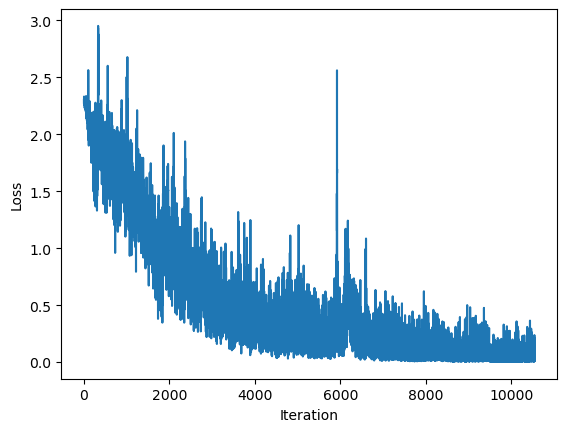

In [1]:
import matplotlib.pyplot as plt
# Tải loss từ file
import pickle
with open('loss_values.pkl', 'rb') as f:  
    loss_values = pickle.load(f)
plt.plot(loss_values)  # Vẽ đồ thị loss
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

#### Đánh giá mô hình

- Sử dụng `model.eval()` để đánh dấu rằng mô hình đang được đánh giá, chứ không phải đang được huấn luyện. 
- Sử dụng `torch.no_grad()` để tắt tính toán gradient trong quá trình đánh giá, giúp tiết kiệm bộ nhớ và tăng tốc độ tính toán.
- Sử dụng `test_loader` để lấy ra các batch dữ liệu để đánh giá mô hình. 
- Với từng `batch` dữ liệu, chúng ta thực hiện các công việc sau:
    - Đưa dữ liệu vào thiết bị `device`, 
    - Tính toán đầu ra của mô hình `outputs` bằng cách đưa vào đầu vào `inputs` và độ dài các chuỗi đầu vào `lengths`. 
    - Sử dụng hàm `torch.max()` để lấy ra nhãn dự đoán của mô hình `predicted` và so sánh với nhãn thực tế `lslabels` để tính toán số lượng dự đoán chính xác `correct` và tổng số lượng mẫu dữ liệu `total`.
- Cuối cùng, tính độ chính xác trung bình của mô hình trên tập dữ liệu kiểm tra `accuracy` bằng cách tính tỷ lệ phần trăm giữa số lượng dự đoán chính xác và tổng số lượng mẫu dữ liệu.

In [ ]:
# Tải mô hình
model = TextClassifier(num_classes, vocab_size, embedding_dim, hidden_size).to(device)
model.load_state_dict(torch.load('model.pth'))

# Đánh giá mô hình
model.eval()
predicted_labels = []
true_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, lengths, labels in test_loader:
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs, lengths)
        _, predicted = torch.max(outputs.data, 1)
        _, lslabels = torch.max(labels, 1)
        total += lslabels.size(0)
        correct += (predicted == lslabels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
    

In [42]:
accuracy = 100 * correct / total
print(f"Accuracy: {accuracy}%")

Accuracy: 87.67792269668274%


In [46]:
from sklearn.metrics import classification_report
import numpy as np
numeric_array = [np.argmax(arr) for arr in true_labels]
labels = [x[1] for x in train_data]
labels = list(sorted(set(labels)))
print(classification_report(numeric_array, predicted_labels, target_names=[label_dict[x][1] for x in labels]))

                  precision    recall  f1-score   support

        Đời sống       0.83      0.83      0.83      7567
      Kinh doanh       0.58      0.54      0.56      2036
        Khoa học       0.65      0.75      0.69      2096
       Pháp luật       0.89      0.86      0.87      5276
        Sức khoẻ       0.87      0.89      0.88      3788
        Thế giới       0.90      0.91      0.91      5417
        Thể thao       0.93      0.88      0.90      6716
         Văn hoá       0.95      0.98      0.97      6667
         Vi tính       0.91      0.92      0.92      6250
Chính trị xã hội       0.92      0.93      0.92      4560

        accuracy                           0.88     50373
       macro avg       0.84      0.85      0.84     50373
    weighted avg       0.88      0.88      0.88     50373



### Sử dụng mô hình để phân loại văn bản

Đây là một chương trình Python được sử dụng để dự đoán thể loại của một đoạn văn bản bất kỳ. Chương trình sử dụng một mô hình học sâu (neural network) để dự đoán thể loại của văn bản đầu vào. Mô hình này đã được đào tạo trước và được sử dụng để phân loại văn bản vào một trong các nhãn được định nghĩa trước (label_dict).

Cụ thể:

- Hàm `normalize_percent(data)` nhận đầu vào là một mảng (array) `data` và trả về một mảng mới `data_normalized` được chuẩn hóa về phần trăm (%). Hàm sử dụng công thức chuẩn hóa min-max để đưa các giá trị trong `data` về đoạn [0, 1], rồi nhân với 100 để đưa về phần trăm.

- Hàm `predict(text)` nhận đầu vào là một đoạn văn bản `text` và trả về một mảng `outputs` chứa xác suất dự đoán cho mỗi nhãn (label) trong `label_dict`. Hàm này sử dụng mô hình đã được đào tạo trước đó (được lưu trong biến `model`) để tính toán xác suất dự đoán. Đầu vào của mô hình là một tensor được chuyển đổi từ đoạn văn bản `text` bằng hàm `sentence_to_num()` và được mã hóa dưới dạng số (sử dụng `vocab_dict` để mã hóa). Kết quả đầu ra của mô hình là một tensor chứa xác suất cho mỗi nhãn.

- Hàm `getLabel(outputs)` nhận đầu vào là một mảng `outputs` chứa xác suất dự đoán cho mỗi nhãn và trả về tên nhãn được dự đoán là chính xác nhất. Hàm này sử dụng tensor `outputs` để lấy nhãn có xác suất cao nhất và trả về tên tương ứng của nhãn đó. Tên nhãn được lấy từ `label_dict` dựa trên mã số của nhãn.

- Hàm `getLabels(outputs)` nhận đầu vào là một mảng `outputs` chứa xác suất dự đoán cho mỗi nhãn và trả về một danh sách các chuỗi chứa tên và xác suất của các nhãn. Hàm này sử dụng tensor `outputs` để lấy xác suất cho mỗi nhãn và chuẩn hóa xác suất đó về phần trăm bằng hàm `normalize_percent()`. Sau đó, hàm sử dụng `label_dict` để lấy tên của mỗi nhãn và kết hợp với xác suất tương ứng để tạo ra một chuỗi kết quả. Danh sách các chuỗi này được trả về.

- Đoạn code cuối cùng sử dụng hàm `predict()` để dự đoán nhãn của một đoạn văn bản `test`. Kết quả dự đoán được trả về dưới dạng một mảng `outputs`. Sau đó, hàm `getLabels()` và `getLabel()` được sử dụng để lấy danh sách các chuỗi kết quả và tên nhãn được dự đoán chính xác nhất. Cuối cùng, đoạn văn bản `test` ban đầu và kết quả dự đoán được in ra màn hình.

In [ ]:
def normalize_percent(data):
    data_normalized = (data - data.min()) / (data.max() - data.min()) * 100
    return data_normalized
# Hàm trả về tên nhãn dự đoán
def predict(text):
    model.eval()
    with torch.no_grad():
        inputs = sentence_to_num(text, vocab_dict).unsqueeze(0).to(device)
        lengths = [inputs.size(1)]
        outputs = model(inputs, lengths)
        return normalize_percent(outputs)

def getLabel(outputs):
    _, predicted = torch.max(outputs.data, 1)
    result = [label_dict[x][1] for x in label_dict if label_dict[x][0] == predicted.item()]
    return result[0]

def getLabels(outputs):
    _, predicted = torch.max(outputs.data, 1)
    data = outputs.data.tolist()[0]
    dict_labels = [v[1] for k,v in label_dict.items()]
    result = []
    for i in range(len(label_dict)) :
      result.append(f'-{dict_labels[i]}: {round(data[i])}%')
    return result

test = test_data[91][0]
outputs = predict(test)
print('Kết quả tính toán:')
print(*getLabels(outputs), sep='\n')
print('Như vậy dự đoán là thuộc thể loại:', getLabel(outputs))
print(test)